# Task 1b - Big Data Scenarios - Prof. Meth

In [56]:
import pandas as pd
import csv

df = pd.read_csv('train_data_w_ingredients.csv', sep=';', error_bad_lines=False, index_col=0)

First look

In [57]:
df.iloc[0]

index                                                          1
name                                         Vietnamese Pho Soup
ingredients    ['8 cups beef broth', '4 cups water', '1 yello...
cuisine                                               Vietnamese
Name: 1, dtype: object

In [58]:
df.head(5)

,index,name,ingredients,cuisine
1,1,Vietnamese Pho Soup,"['8 cups beef broth', '4 cups water', '1 yello...",Vietnamese
2,2,Vietnamese Chicken Meatballs,"['1 pound ground chicken', '3 tablespoons fish...",Vietnamese
3,3,Vietnamese Restaurant-Style Grilled Lemongrass...,"['1 pound pork blade steaks (boneless, about 1...",Vietnamese
4,4,Vietnamese Caramel Chicken,"['1 pound chicken thighs (with skin, deboned)'...",Vietnamese
5,5,Cheater Vietnamese Pho (Pho Bo),"['3 marrow bones (beef bone)', '50 ounces beef...",Vietnamese


In [59]:
print("Document Count")
print(df.groupby('cuisine')['ingredients'].count())

Document Count
cuisine
Chinese       60
Greek         50
Iberic        40
Italian       50
Thai          50
Vietnamese    50
french        50
korean        50
Name: ingredients, dtype: int64


#### Interpretation
Man kann sehen, dass es im Schnitt 50 Rezepte für jede Küchenart gibt. Unsere beiden Küchenarten stechen dabei heraus, da wir 60 Chinesische Rezepte haben und nur 40 ibirische Rezepte.

## Blick auf die Daten

In [60]:
df['ingredients'].iloc[0]

"['8 cups beef broth', '4 cups water', '1 yellow onion (medium, quartered)', '4 cloves garlic (roughly minced)', '3 whole star anise (optional if you don’t like the flavor)', '3 whole cloves (talking about the spice, “cloves”)', '1 ginger (3-inch knob of, sliced into coins)', '1 cinnamon stick', '2 tablespoons fish sauce (optional)', 'salt', 'black pepper', '1 package rice noodles (look for the word “pho” on the package)', '12 ounces steak (very thinly sliced against the grain, I used flank steak)', 'bean sprouts (optional)', 'fresh cilantro (optional)', 'fresh ginger (optional)', 'lime wedges (optional)', 'green onions (optional)', 'jalapenos (optional)', 'thai basil (optional)']"

#### Interpretation
Man kann erkennen das viele Wörter & Symbole unnötig sind (Einheiten, Zahlen, Punctiation). Auch die typischen Stopwords müssen gefiltert werden. Zum verdeutlichen führen wir einen kurzen Test durch indem wir die 30 häufigsten Wörter anschauen

In [61]:
from collections import Counter
df['ingredients'] = df['ingredients']
Counter(" ".join(df["ingredients"]).split()).most_common(30)

[("'1", 1637),
 ("'2", 795),
 ('cup', 733),
 ('teaspoon', 689),
 ('tablespoons', 609),
 ("'1/2", 502),
 ('tablespoon', 458),
 ("'1/4", 331),
 ("'3", 323),
 ('garlic', 273),
 ('cups', 270),
 ("oil',", 266),
 ('and', 239),
 ("sauce',", 237),
 ('1/2', 227),
 ("'4", 217),
 ('fresh', 208),
 ('cloves', 200),
 ('into', 187),
 ('ounces', 182),
 ('teaspoons', 182),
 ('red', 181),
 ('chicken', 163),
 ('ground', 159),
 ("['1", 153),
 ('or', 149),
 ("salt',", 148),
 ('soy', 146),
 ('pound', 144),
 ('olive', 143)]

Die Vermutung lässt also sehr leicht bestätigen indem man die obere Liste betrachtet. 
Nur die nachfolgenden Begriff können alleinstehend als tatsächliche Zutat erkennen:
- garlic
- chicken
- salt
- soy 
- olive

Also gerade einmal 5/30 Zutaten.


# Preprocessing

https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

Erzeugen von drei zusätzlichen Dataframes

In [62]:
#only our cuisines
new_df = df.loc[(df['cuisine'] == 'Chinese') | (df['cuisine'] == 'Iberic')]

new_df.drop(["index"], axis=1, inplace=True)
new_df.drop(["name"], axis=1, inplace=True)
new_df=new_df.reindex(columns=['cuisine','ingredients'])
new_df.head()

/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,cuisine,ingredients
301,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre..."
302,Chinese,"['6 chicken thighs (free range)', '2 tablespoo..."
303,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be..."
304,Chinese,"['1 pound lean beef (cut into thin strips)', '..."
305,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre..."


## Erstellung von Wörterlisten

In [63]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['teaspoon','teaspoons''cloves','clove','ounces','tablespoons','litrbes','liter','millilitres','mL','grams','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','cups','c','pottle','gill','dram','wineglass','coffeespoon','pound','pounded','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree']

#measures = [lemmatizer.lemmatize(m) for m in measures]
#some of these include data leakage words, like 'italian' - ok to remove after including bigrams
data_leaks = ['iberic','greek', 'korean','italianstyle', 'french','thai', 'chinese', 'mexican','spanish','indian','italian']

common_remove=['fine','ground','to','taste', 'and', 'or',  'can',  'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','dry','thinly','cubed','bunch','cube','slice','pod','beaten','seeded','uncooked','root','plain','heavy','halved','crumbled','sweet','with','hot','room','temperature','trimmed','allpurpose','deveined','bulk','seasoning','jar','food','if','bag','mix','in','each','roll','instant','double','such','frying','thawed','whipping','stock','rinsed','mild','sprig','freshly','toasted','link','boiling','cooked','unsalted','container',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','floret','coarsely','the','blanched','zested','sweetened','powdered','garnish','dressing','soup','at','active','lean','chip','sour','long','ripe','skinned','fillet','from','stem','flaked','removed','stalk','unsweetened','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring',  'undrained', 'about', 'zest', ' ', '', 'spray', 'round', 'herb', 'seasoned', 'wedge', 'bitesize', 'broken', 'square', 'freshly', 'thickly', 'diagonally']
#common_remove = [lemmatizer.lemmatize(c) for c in common_remove]
#data_leaks = [lemmatizer.lemmatize(d) for d in data_leaks]
# due to using bigrams not including 
useless_singles=['','black','white','red','yellow','seed','breast','confectioner','sundried','broth','bell','baby','juice','crumb','sauce','condensed','smoked','basmati','extravirgin','brown','clarified', 'soy', 'filling', 'pine', 'virgin', 'romano', 'heart', 'shell', 'thigh', 'boneless','skinless','split', 'dark', 'wheat', 'light', 'green', 'vegetable', 'curry', 'orange', 'garam', 'sesame', 'strip', 'sea', 'canola', 'mustard','powder', 'ice', 'bay', 'roasted', 'loaf', 'roast', 'powder']
useless_singles = [lemmatizer.lemmatize(u) for u in useless_singles]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

In [64]:
def remove_unwanted(i):
    cl = i.strip('[]')
    return cl

new_df['ingredients_list'] = new_df['ingredients'].map(lambda s:remove_unwanted(s).split(","))
new_df.head(1)

,cuisine,ingredients,ingredients_list
301,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr..."


In [65]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence) #stringify
    sentence = sentence.lower() #kleinschreibung
    sentence = re.sub("\(.*?\)","()",sentence) #Alternativen entfernen - also alles zwischen ( )
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    filtered_words = [w for w in filtered_words if not w in measures]
    filtered_words = [w for w in filtered_words if not w in data_leaks]
    filtered_words = [w for w in filtered_words if not w in common_remove]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)


# Apply to the DF series
new_df['cleanText']=new_df['ingredients'].map(lambda s:preprocess(s)) 
new_df['cleanTextList']=new_df['ingredients'].map(lambda s:preprocess(s).split()) 
new_df.head(3)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList
301,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr...",clove garlic ginger sesam oil rice vinegar soy...,"[clove, garlic, ginger, sesam, oil, rice, vine..."
302,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken thigh oliv oil ginger clove garlic hon...,"[chicken, thigh, oliv, oil, ginger, clove, gar..."
303,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg yellow onion carrot pea clove garli...,"[butter, egg, yellow, onion, carrot, pea, clov..."


### Generate Bigrams

In [66]:
new_df['bigrams'] = new_df['cleanText'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
new_df.head()

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams
301,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr...",clove garlic ginger sesam oil rice vinegar soy...,"[clove, garlic, ginger, sesam, oil, rice, vine...","[(clove, garlic), (garlic, ginger), (ginger, s..."
302,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken thigh oliv oil ginger clove garlic hon...,"[chicken, thigh, oliv, oil, ginger, clove, gar...","[(chicken, thigh), (thigh, oliv), (oliv, oil),..."
303,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg yellow onion carrot pea clove garli...,"[butter, egg, yellow, onion, carrot, pea, clov...","[(butter, egg), (egg, yellow), (yellow, onion)..."
304,Chinese,"['1 pound lean beef (cut into thin strips)', '...","['1 pound lean beef (cut into thin strips)', ...",beef soy sauc sherri oil yellow onion garlic g...,"[beef, soy, sauc, sherri, oil, yellow, onion, ...","[(beef, soy), (soy, sauc), (sauc, sherri), (sh..."
305,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr...",clove garlic ginger sesam oil rice vinegar soy...,"[clove, garlic, ginger, sesam, oil, rice, vine...","[(clove, garlic), (garlic, ginger), (ginger, s..."


# Task 1b/a

## Task 1b/a Absolute number of ingredients

In [67]:
def count_ingredients (i):
    num = len(i)
    return num

new_df['number of ingredients'] = new_df['ingredients_list'].apply(count_ingredients)
new_df['CLEAN number of ingredients'] = new_df['cleanTextList'].apply(count_ingredients)
new_df.sample(5)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams,number of ingredients,CLEAN number of ingredients
363,Iberic,"['2/3 cup butter (softened)', '1 1/4 cups gran...","['2/3 cup butter (softened)', '1 1/4 cups gra...",butter granul sugar egg orang purpos flour bak...,"[butter, granul, sugar, egg, orang, purpos, fl...","[(butter, granul), (granul, sugar), (sugar, eg...",10,11
383,Iberic,"['1 cup long grain rice', '2 cups water', '1/4...","['1 cup long grain rice', '2 cups water', '1...",grain rice water onion garlic clove tomato cum...,"[grain, rice, water, onion, garlic, clove, tom...","[(grain, rice), (rice, water), (water, onion),...",9,14
327,Chinese,"['1 1/2 cups chicken broth', '4 pounds baby ba...","['1 1/2 cups chicken broth', '4 pounds baby b...",chicken broth pound babi back rib salt black p...,"[chicken, broth, pound, babi, back, rib, salt,...","[(chicken, broth), (broth, pound), (pound, bab...",8,18
348,Chinese,"['2 tablespoons canola oil', '1/3 cup rice vin...","['2 tablespoons canola oil', '1/3 cup rice vi...",canola oil rice vinegar hoisin sauc soy sauc g...,"[canola, oil, rice, vinegar, hoisin, sauc, soy...","[(canola, oil), (oil, rice), (rice, vinegar), ...",15,24
322,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg yellow onion carrot pea clove garli...,"[butter, egg, yellow, onion, carrot, pea, clov...","[(butter, egg), (egg, yellow), (yellow, onion)...",11,16


In [68]:
chinese = new_df.loc[(df['cuisine'] == 'Chinese')]
iberic = new_df.loc[(df['cuisine'] == 'Iberic')]

## Result:

### Chinese & Iberic

In [69]:
Total = new_df['number of ingredients'].sum()
Total

1288

### Only chinese

In [70]:
chineseTotal = chinese['number of ingredients'].sum()
chineseTotal

803

### Only iberic

In [71]:
ibericTotal = iberic['number of ingredients'].sum()
ibericTotal

485

## Task 1b/b Relative number of different ingredients

In [72]:
print('Ingredients List:')
print(new_df['ingredients_list'].iloc[0])
print('Anzahl:')
print(len(new_df['ingredients_list'].iloc[0]))
print()
print('After cleanup:')
print(new_df['cleanTextList'].iloc[0])
print('Anzahl:')
print(len(new_df['cleanTextList'].iloc[0]))

Ingredients List:
["'2 cloves garlic (minced)'", " '1 tablespoon fresh ginger (chopped fine)'", " '1 teaspoon sesame oil'", " '2 tablespoons rice vinegar'", " '1/3 cup soy sauce'", " '1/2 cup chicken broth (vegetable broth or even water)'", " '1 tablespoon Sriracha'", " '2 tablespoons sugar'", " '1 1/2 tablespoons corn starch'"]
Anzahl:
9

After cleanup:
['clove', 'garlic', 'ginger', 'sesam', 'oil', 'rice', 'vinegar', 'soy', 'sauc', 'chicken', 'broth', 'sriracha', 'sugar', 'corn', 'starch']
Anzahl:
15


Man sieht das nach dem aufräumen die Zutatliste deutlich anders aussieht. Die Anhzahl der Zutaten selbst hat sich auch deutlich verändert. Das liegt an den Zutaten die aus zwei Wörtern bestehen. In unserem Beispiel "corn starch" wird nach dem cleanup zu "corn", "starch".

Dennoch ist es sinnvoll mit den bereinigten Zutaten zu arbeiten, da die Bestimmung von unterschiedlichen Zutaten auf Basis der unbereinigten Zutaten zu Problem führt: 

- Die Anzahl der Zutaten, also z.B. 2 oder 1 würde als unterschiedliche Zutat beurteilt werden.
- Die Zutaten selbst könnten durch unterschiedliche Einheiten nicht als gleich identifiziert werden (Cups vs tablespoons)

## Result:

In [73]:
TotalClean = new_df['CLEAN number of ingredients'].sum()
TotalCleanChinese = chinese['CLEAN number of ingredients'].sum()
TotalCleanIberic = iberic['CLEAN number of ingredients'].sum()
print('Absolut number Chinese & Iberic: ' + str(TotalClean))
print()
print('Absolut number Chinese: ' + str(TotalCleanChinese))
print()
print('Absolut number Iberic: ' + str(TotalCleanIberic))

Absolut number Chinese & Iberic: 1975

Absolut number Chinese: 1280

Absolut number Iberic: 695


In [74]:
#Chinese & Iberic
results = Counter()
new_df['cleanTextList'].apply(results.update)

#Chinese
resultsChinese = Counter()
chinese['cleanTextList'].apply(resultsChinese.update)

#Iberic
resultsIberic = Counter()
iberic['cleanTextList'].apply(resultsIberic.update)

print('Different Ingredients Chinese & Iberic: ' + str(len(results)))
print()
print('Different Ingredients Chinese: ' + str(len(resultsChinese)))
print()
print('Different Ingredients Iberic: ' + str(len(resultsIberic)))

Different Ingredients Chinese & Iberic: 229

Different Ingredients Chinese: 128

Different Ingredients Iberic: 172


## Absolute number of different ingredients / Absolute number of ingredients

#### Chinese & Iberic

In [75]:
a = TotalClean/len(results)
print(a)
print()
print(results)

8.624454148471616

Counter({'oil': 111, 'sauc': 93, 'garlic': 76, 'pepper': 65, 'salt': 64, 'soy': 60, 'onion': 57, 'teaspoon': 52, 'clove': 48, 'chicken': 48, 'egg': 44, 'rice': 41, 'sugar': 41, 'ginger': 39, 'water': 37, 'oliv': 36, 'sesam': 31, 'white': 29, 'vinegar': 25, 'black': 25, 'cornstarch': 24, 'red': 23, 'wine': 22, 'green': 21, 'bean': 19, 'tomato': 19, 'carrot': 18, 'veget': 18, 'boneless': 17, 'pound': 17, 'flour': 17, 'powder': 17, 'honey': 16, 'paprika': 15, 'seed': 14, 'skinless': 14, 'breast': 14, 'canola': 14, 'cabbag': 13, 'lemon': 13, 'broth': 12, 'sprout': 12, 'orang': 12, 'dark': 11, 'broccoli': 11, 'bell': 11, 'sodium': 11, 'oregano': 11, 'thigh': 10, 'yellow': 10, 'brown': 10, 'scallion': 10, 'pork': 10, 'chili': 10, 'potato': 10, 'hoisin': 9, 'oyster': 9, 'peanut': 9, 'juic': 9, 'butter': 8, 'pea': 8, 'beef': 8, 'low': 8, 'granul': 7, 'fish': 7, 'cilantro': 7, 'cumin': 7, 'sriracha': 6, 'sherri': 6, 'light': 6, 'noodl': 6, 'sausag': 6, 'napa': 6, 'chorizo': 6

### Only chinese

In [76]:
b = TotalCleanChinese/len(resultsChinese)
print(b)
print()
print(resultsChinese)

10.0

Counter({'sauc': 89, 'oil': 76, 'soy': 60, 'garlic': 47, 'teaspoon': 41, 'ginger': 39, 'chicken': 37, 'onion': 34, 'egg': 32, 'rice': 31, 'pepper': 31, 'sesam': 29, 'clove': 28, 'sugar': 28, 'water': 27, 'salt': 27, 'cornstarch': 24, 'vinegar': 23, 'white': 18, 'carrot': 16, 'green': 16, 'black': 16, 'honey': 15, 'veget': 15, 'boneless': 14, 'breast': 14, 'wine': 14, 'bean': 13, 'skinless': 13, 'canola': 13, 'seed': 12, 'sprout': 12, 'flour': 12, 'cabbag': 12, 'broccoli': 11, 'pound': 11, 'dark': 10, 'brown': 10, 'powder': 10, 'red': 10, 'hoisin': 9, 'oyster': 9, 'scallion': 9, 'peanut': 9, 'yellow': 8, 'sodium': 8, 'orang': 8, 'broth': 7, 'pea': 7, 'beef': 7, 'pork': 7, 'sriracha': 6, 'thigh': 6, 'light': 6, 'noodl': 6, 'napa': 6, 'sherri': 5, 'floret': 5, 'sirloin': 5, 'steak': 5, 'low': 5, 'mushroom': 5, 'chili': 5, 'corn': 4, 'starch': 4, 'oliv': 4, 'spring': 4, 'chow': 4, 'mein': 4, 'shaox': 4, 'turmer': 4, 'granul': 4, 'juic': 4, 'butter': 3, 'bake': 3, 'spice': 3, 'shiitak

### Only iberic

In [77]:
i = TotalCleanIberic/len(resultsIberic)
print(i)
print()
print(resultsIberic)

4.040697674418604

Counter({'salt': 37, 'oil': 35, 'pepper': 34, 'oliv': 32, 'garlic': 29, 'onion': 23, 'clove': 20, 'tomato': 18, 'red': 13, 'sugar': 13, 'paprika': 13, 'egg': 12, 'chicken': 11, 'white': 11, 'oregano': 11, 'teaspoon': 11, 'potato': 10, 'water': 10, 'lemon': 10, 'rice': 10, 'bell': 9, 'black': 9, 'wine': 8, 'powder': 7, 'cumin': 7, 'bean': 6, 'pound': 6, 'chorizo': 6, 'milk': 6, 'virgin': 6, 'cilantro': 6, 'butter': 5, 'flour': 5, 'broth': 5, 'green': 5, 'parsley': 5, 'chili': 5, 'sea': 5, 'juic': 5, 'sausag': 4, 'sauc': 4, 'orang': 4, 'millilit': 4, 'cinnamon': 4, 'fish': 4, 'roast': 4, 'kosher': 4, 'grain': 4, 'smoke': 4, 'thigh': 4, 'flake': 3, 'granul': 3, 'purpos': 3, 'shallot': 3, 'bread': 3, 'veget': 3, 'jalapeno': 3, 'chees': 3, 'thyme': 3, 'pork': 3, 'babi': 3, 'boneless': 3, 'low': 3, 'sodium': 3, 'carrot': 2, 'kale': 2, 'kidney': 2, 'celeri': 2, 'linguica': 2, 'pinto': 2, 'kilogram': 2, 'fillet': 2, 'stem': 2, 'basil': 2, 'new': 2, 'yeast': 2, 'port': 2, 'ha

## Task 1b/c Top 10 most frequent ingredients

In [78]:
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt 
import pandas as pd

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(new_df['cleanText'], 10)
chinese_common_words = get_top_n_words(chinese['cleanText'], 10)
iberic_common_words = get_top_n_words(iberic['cleanText'], 10)

df1 = pd.DataFrame(common_words, columns = ['Ingredient' , 'Count'])
df1c = pd.DataFrame(chinese_common_words, columns = ['IngredientChinese' , 'CountChinese'])
df1i = pd.DataFrame(iberic_common_words, columns = ['IngredientIberic' , 'CountIberic'])

most_frequent_single = pd.concat([df1, df1c, df1i ], axis=1)


most_frequent_single.head(10)

,Ingredient,Count,IngredientChinese,CountChinese,IngredientIberic,CountIberic
0,oil,111,sauc,89,salt,37
1,sauc,93,oil,76,oil,35
2,garlic,76,soy,60,pepper,34
3,pepper,65,garlic,47,oliv,32
4,salt,64,teaspoon,41,garlic,29
5,soy,60,ginger,39,onion,23
6,onion,57,chicken,37,clove,20
7,teaspoon,52,onion,34,tomato,18
8,clove,48,egg,32,red,13
9,chicken,48,rice,31,sugar,13


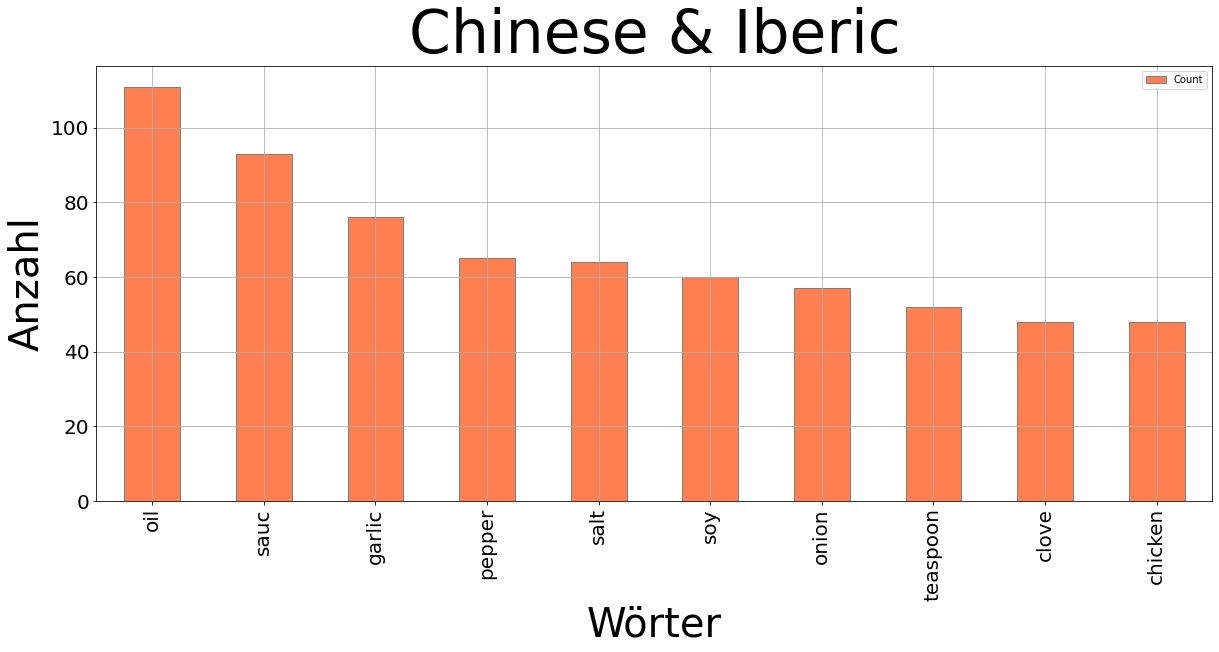

In [79]:
df1.plot.bar(x='Ingredient',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         xlabel = 'xlabel',
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

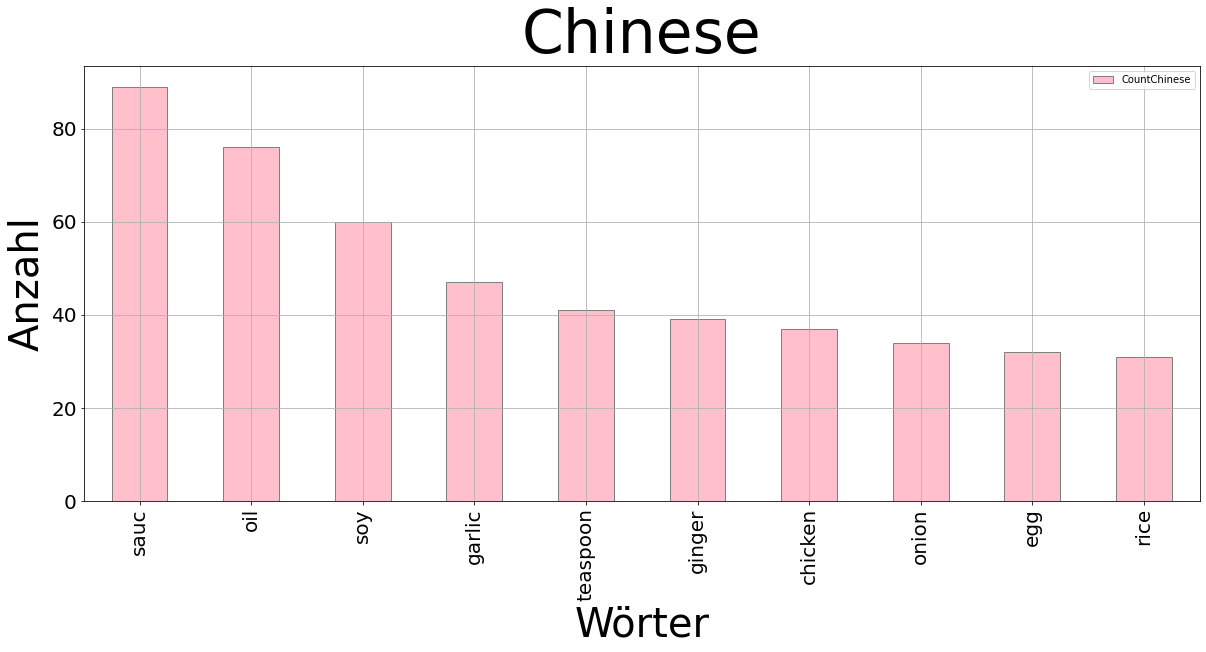

In [80]:
df1c.plot.bar(x='IngredientChinese',
         y='CountChinese', 
         color=['pink'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Chinese.png', bbox_inches = 'tight')
plt.show()

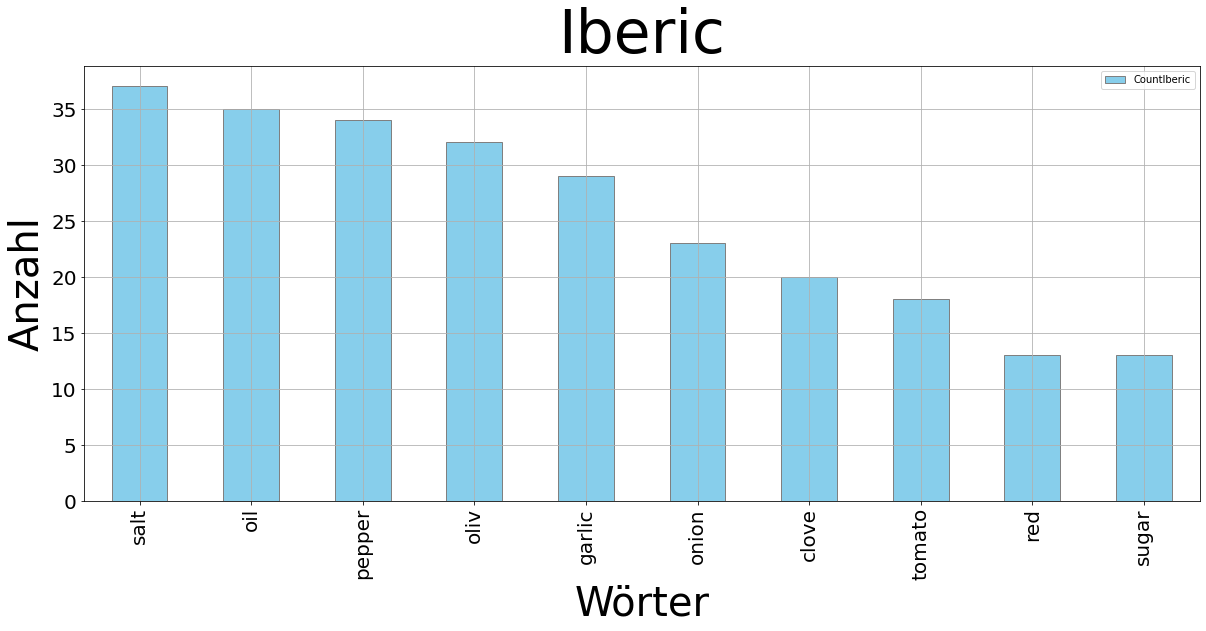

In [81]:
df1i.plot.bar(x='IngredientIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/c Top 10 most frequent bigrams

In [82]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_bigram(new_df['cleanText'], 10)
chinese_common_words = get_top_n_bigram(chinese['cleanText'], 10)
iberic_common_words = get_top_n_bigram(iberic['cleanText'], 10)

df2 = pd.DataFrame(common_words, columns = ['Ingredient' , 'Count'])
df2c = pd.DataFrame(chinese_common_words, columns = ['IngredientChinese' , 'CountChinese'])
df2i = pd.DataFrame(iberic_common_words, columns = ['IngredientIberic' , 'CountIberic'])

most_frequent_bigram = pd.concat([df2, df2c, df2i ], axis=1)


most_frequent_bigram.head(10)

,Ingredient,Count,IngredientChinese,CountChinese,IngredientIberic,CountIberic
0,soy sauc,60,soy sauc,60,oliv oil,30
1,clove garlic,36,clove garlic,24,clove garlic,12
2,oliv oil,34,sesam oil,18,bell pepper,9
3,black pepper,22,green onion,15,black pepper,9
4,sesam oil,19,veget oil,15,garlic clove,8
5,veget oil,17,chicken breast,14,salt black,8
6,green onion,15,garlic ginger,13,salt pepper,7
7,chicken breast,14,black pepper,13,virgin oliv,6
8,garlic ginger,13,sauc teaspoon,12,white wine,5
9,skinless chicken,13,bean sprout,12,red bell,5


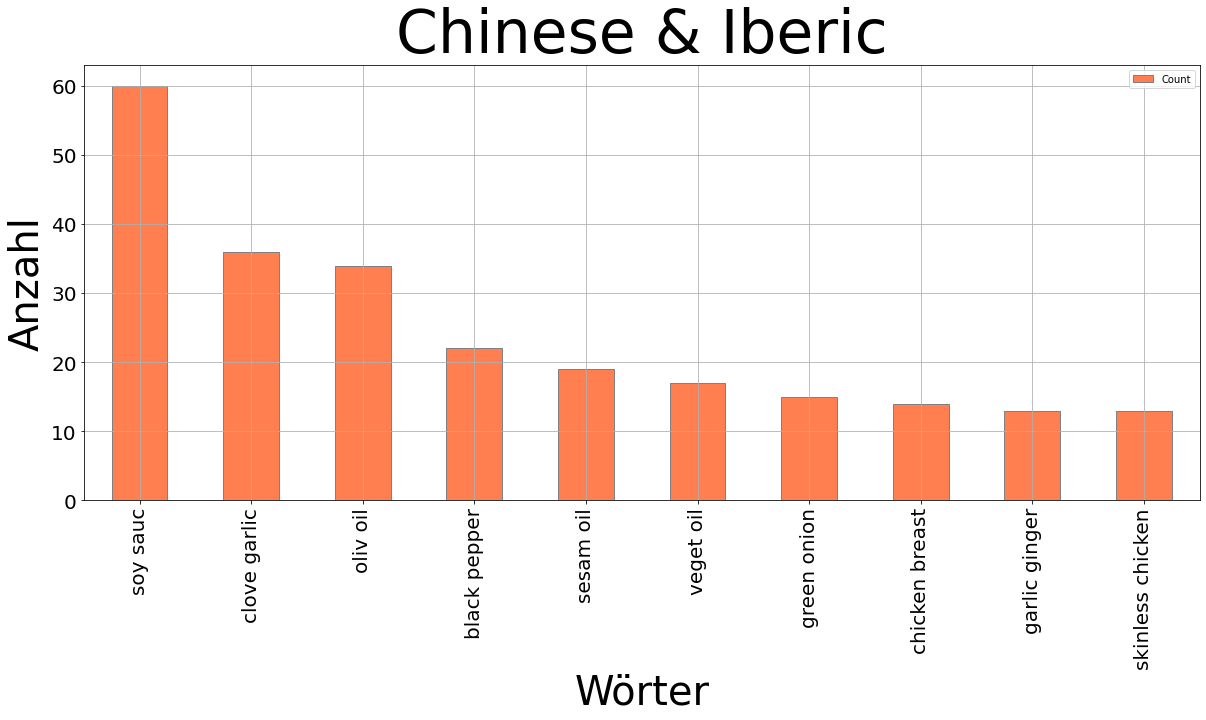

In [83]:
df2.plot.bar(x='Ingredient',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         xlabel = 'xlabel',
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

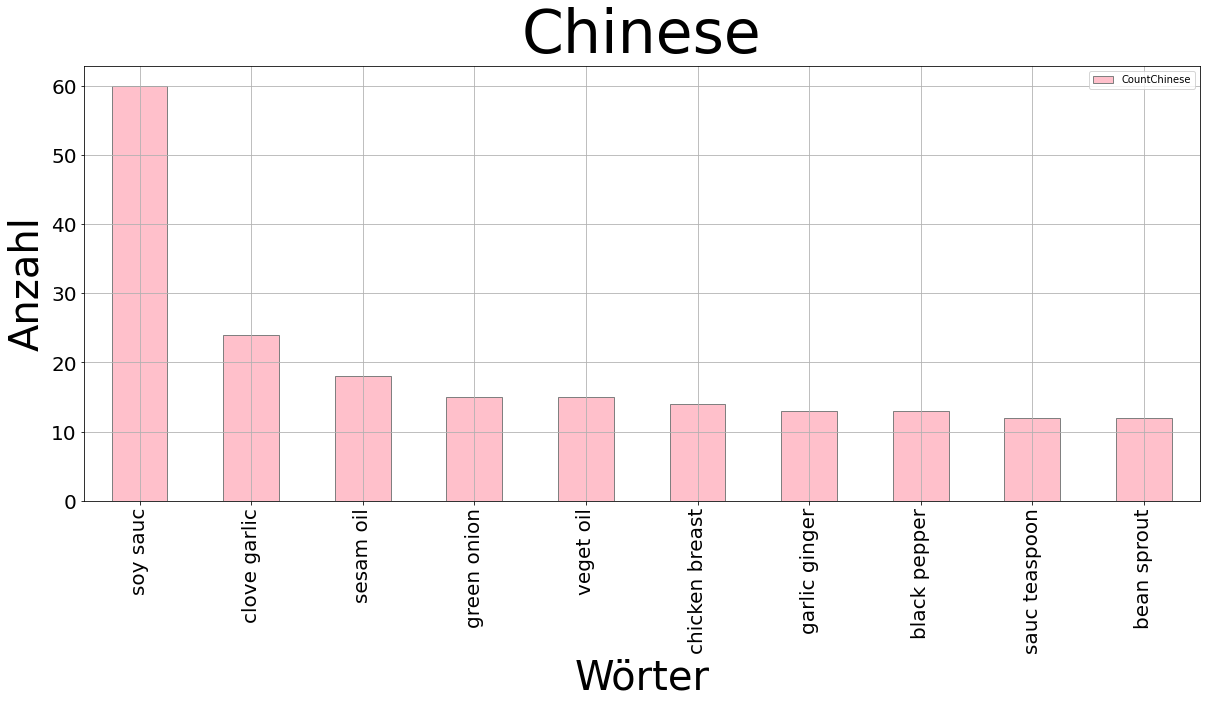

In [84]:
df2c.plot.bar(x='IngredientChinese',
         y='CountChinese', 
         color=['pink'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Chinese.png', bbox_inches = 'tight')
plt.show()

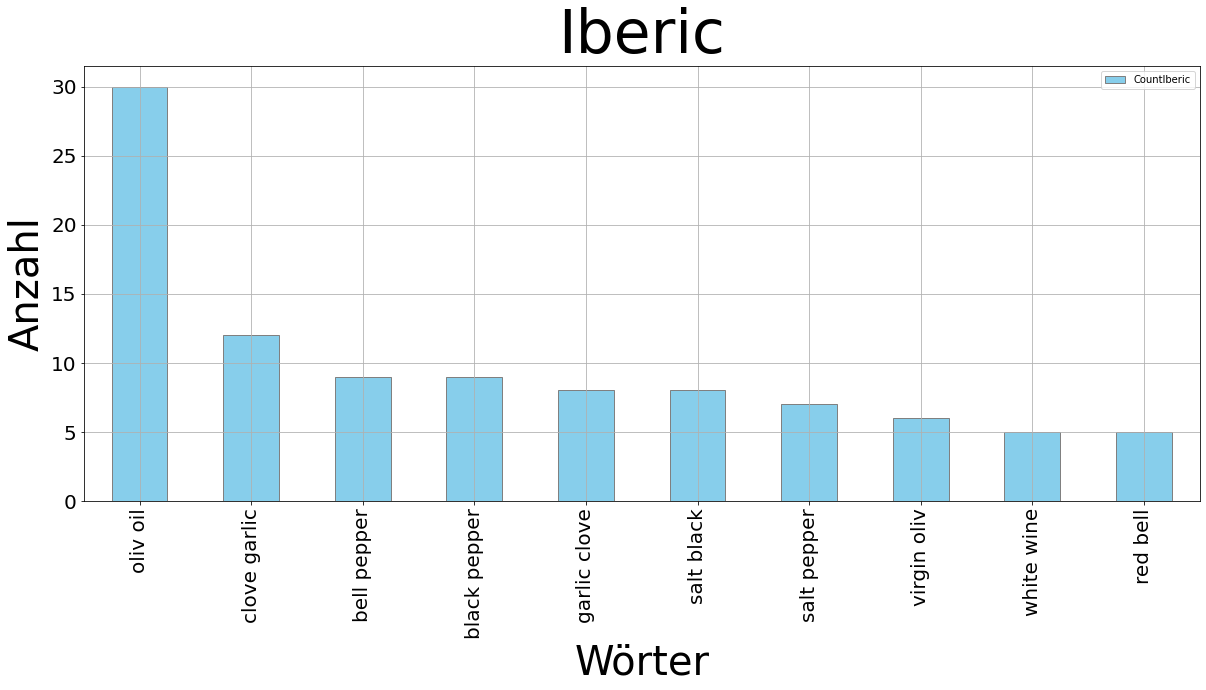

In [85]:
df2i.plot.bar(x='IngredientIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/d Top 10 most frequent ingredient combinations single

In [90]:
import itertools


def generate_combinations (a_list):
    combinations =[]
    
    for i in a_list:
        for pair in itertools.combinations(i,2):
            combinations.append(pair)
            
    return Counter(elem[0:2] for elem in combinations)

In [91]:
ac = generate_combinations(new_df['cleanTextList'])
cc = generate_combinations(chinese['cleanTextList'])
ic = generate_combinations(iberic['cleanTextList'])

df3 = pd.DataFrame.from_records(ac.most_common(10), columns=['Combination','Count'])
df3c = pd.DataFrame.from_records(cc.most_common(10), columns=['CombinationChinese','CountChinese'])
df3i = pd.DataFrame.from_records(ic.most_common(10), columns=['CombinationIberic','CountIberic'])

most_frequent_single_combination = pd.concat([df3, df3c, df3i ], axis=1)

most_frequent_single_combination.head(10)

,Combination,Count,CombinationChinese,CountChinese,CombinationIberic,CountIberic
0,"(soy, sauc)",82,"(soy, sauc)",82,"(oliv, oil)",38
1,"(garlic, sauc)",64,"(garlic, sauc)",62,"(oil, salt)",30
2,"(oil, sauc)",55,"(oil, sauc)",53,"(onion, pepper)",28
3,"(garlic, oil)",54,"(sauc, oil)",52,"(oliv, salt)",26
4,"(oil, oil)",54,"(chicken, sauc)",49,"(garlic, salt)",26
5,"(sauc, oil)",52,"(oil, oil)",47,"(oil, pepper)",24
6,"(chicken, sauc)",50,"(soy, oil)",44,"(salt, pepper)",23
7,"(oil, salt)",50,"(sauc, sauc)",43,"(pepper, salt)",22
8,"(teaspoon, oil)",49,"(clove, sauc)",41,"(onion, salt)",21
9,"(oil, garlic)",46,"(teaspoon, oil)",41,"(red, pepper)",21


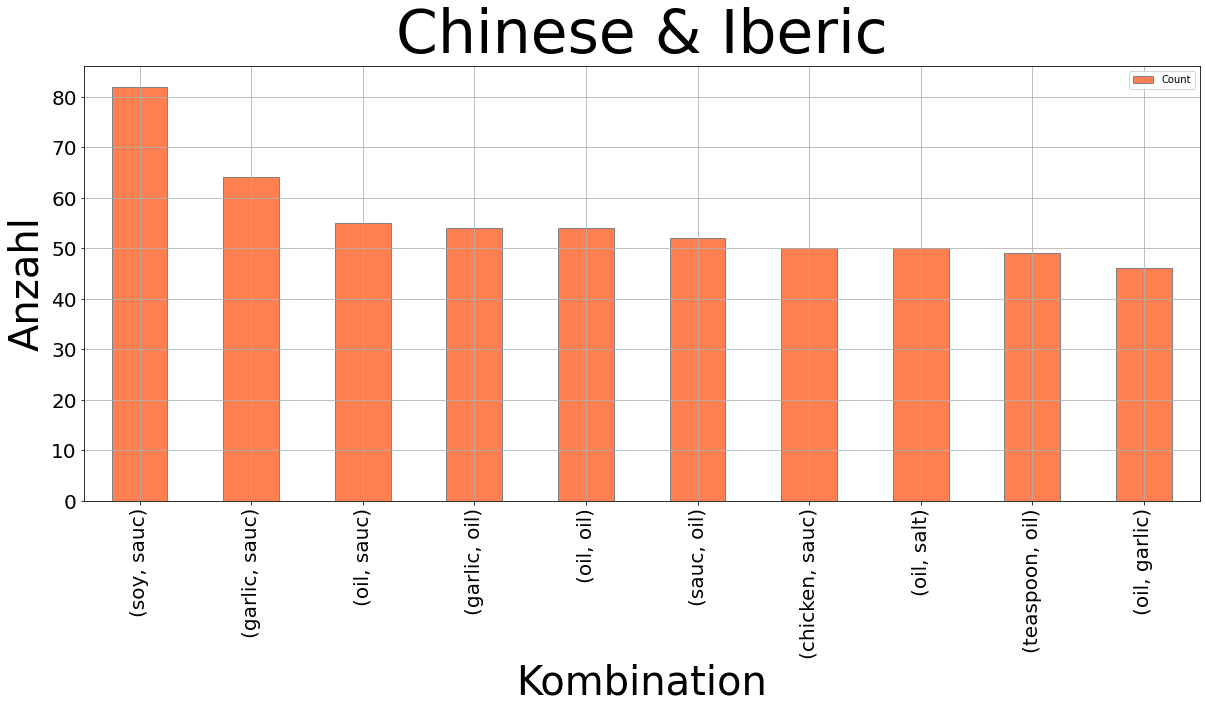

In [92]:
df3.plot.bar(x='Combination',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         xlabel = 'xlabel',
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

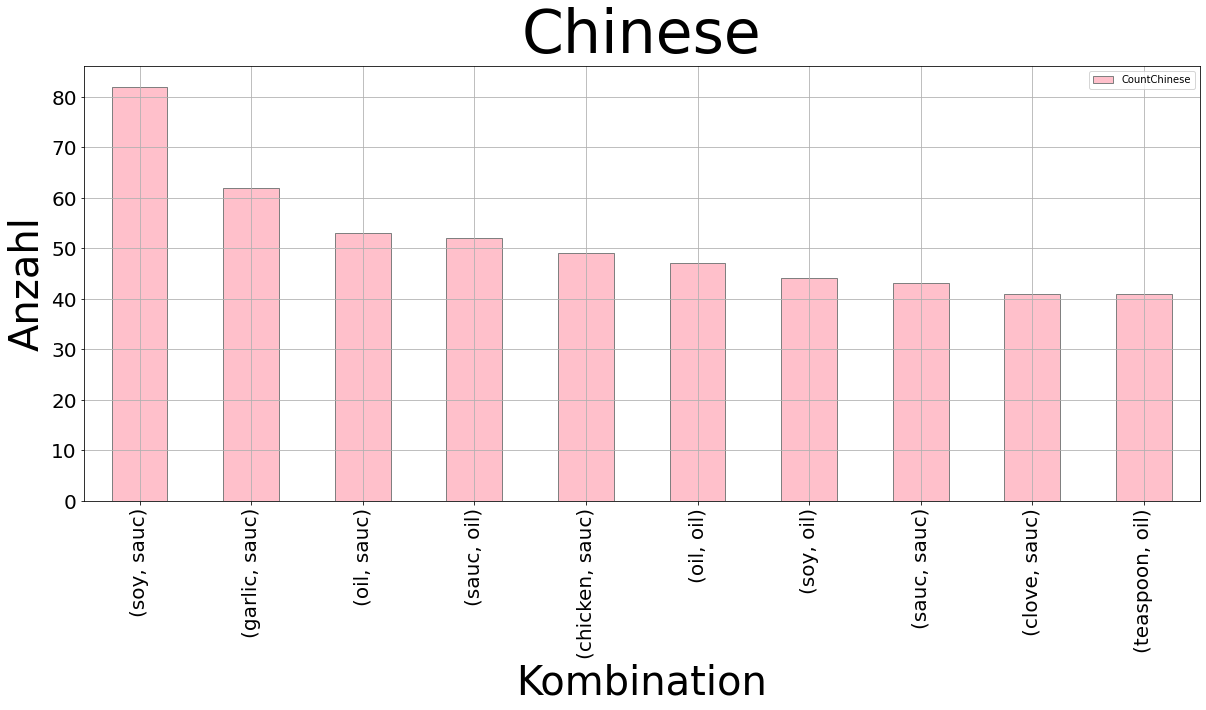

In [98]:
df3c.plot.bar(x='CombinationChinese',
         y='CountChinese', 
         color=['pink'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Chinese.png', bbox_inches = 'tight')
plt.show()

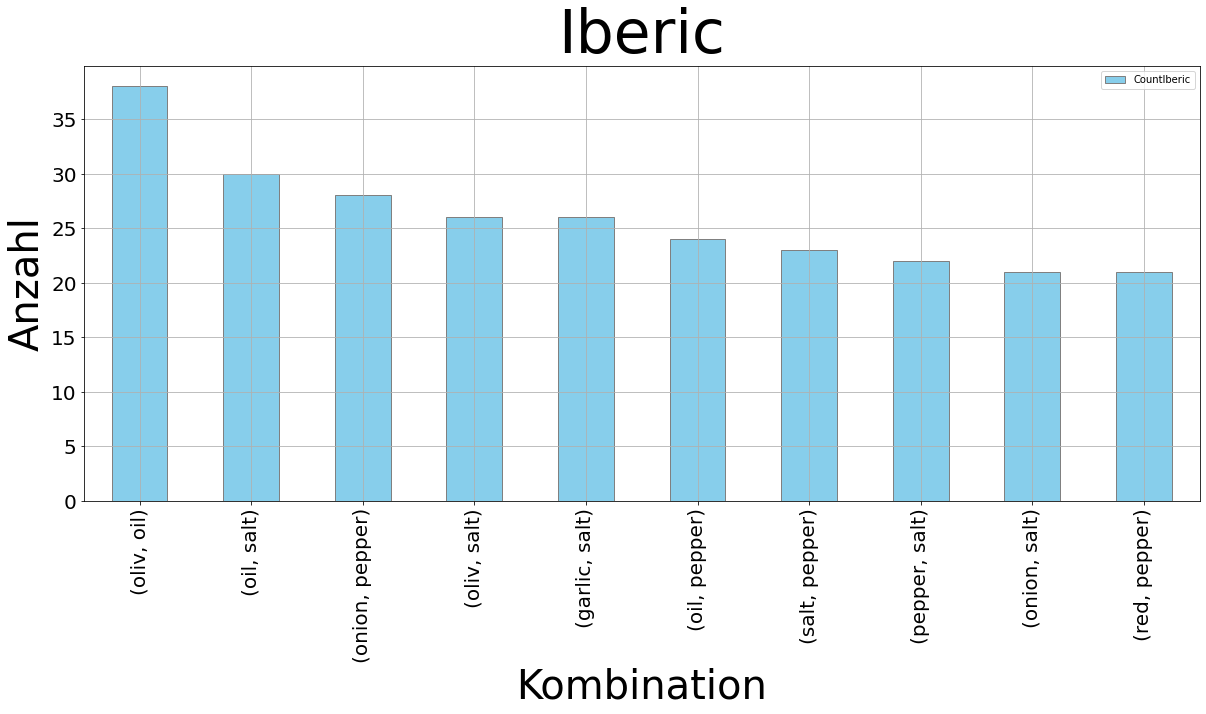

In [99]:
df3i.plot.bar(x='CombinationIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/d Top 10 most frequent ingredient combinations bigrams

In [96]:
abc = generate_combinations(new_df['bigrams'])
cbc = generate_combinations(chinese['bigrams'])
ibc = generate_combinations(iberic['bigrams'])

df4 = pd.DataFrame.from_records(abc.most_common(10), columns=['Combination','Count'])
df4c = pd.DataFrame.from_records(cbc.most_common(10), columns=['CombinationChinese','CountChinese'])
df4i = pd.DataFrame.from_records(ibc.most_common(10), columns=['CombinationIberic','CountIberic'])

most_frequent_single_combination = pd.concat([df4, df4c, df4i ], axis=1)

most_frequent_single_combination.head(10)

,Combination,Count,CombinationChinese,CountChinese,CombinationIberic,CountIberic
0,"((clove, garlic), (soy, sauc))",22,"((clove, garlic), (soy, sauc))",22,"((virgin, oliv), (oliv, oil))",8
1,"((soy, sauc), (sesam, oil))",14,"((soy, sauc), (sesam, oil))",14,"((salt, black), (black, pepper))",8
2,"((soy, sauc), (sauc, water))",13,"((soy, sauc), (sauc, water))",13,"((clove, garlic), (oliv, oil))",6
3,"((skinless, chicken), (chicken, breast))",12,"((skinless, chicken), (chicken, breast))",12,"((oliv, oil), (salt, pepper))",6
4,"((garlic, ginger), (soy, sauc))",11,"((garlic, ginger), (soy, sauc))",11,"((oliv, oil), (black, pepper))",6
5,"((soy, sauc), (sauc, teaspoon))",11,"((soy, sauc), (sauc, teaspoon))",11,"((oliv, oil), (oliv, oil))",6
6,"((soy, sauc), (sesam, seed))",11,"((soy, sauc), (sesam, seed))",11,"((garlic, oliv), (oliv, oil))",5
7,"((salt, black), (black, pepper))",11,"((skinless, chicken), (soy, sauc))",11,"((oliv, oil), (salt, black))",5
8,"((skinless, chicken), (soy, sauc))",11,"((chicken, breast), (soy, sauc))",11,"((red, bell), (bell, pepper))",5
9,"((chicken, breast), (soy, sauc))",11,"((sesam, oil), (soy, sauc))",10,"((potato, oliv), (oliv, oil))",5


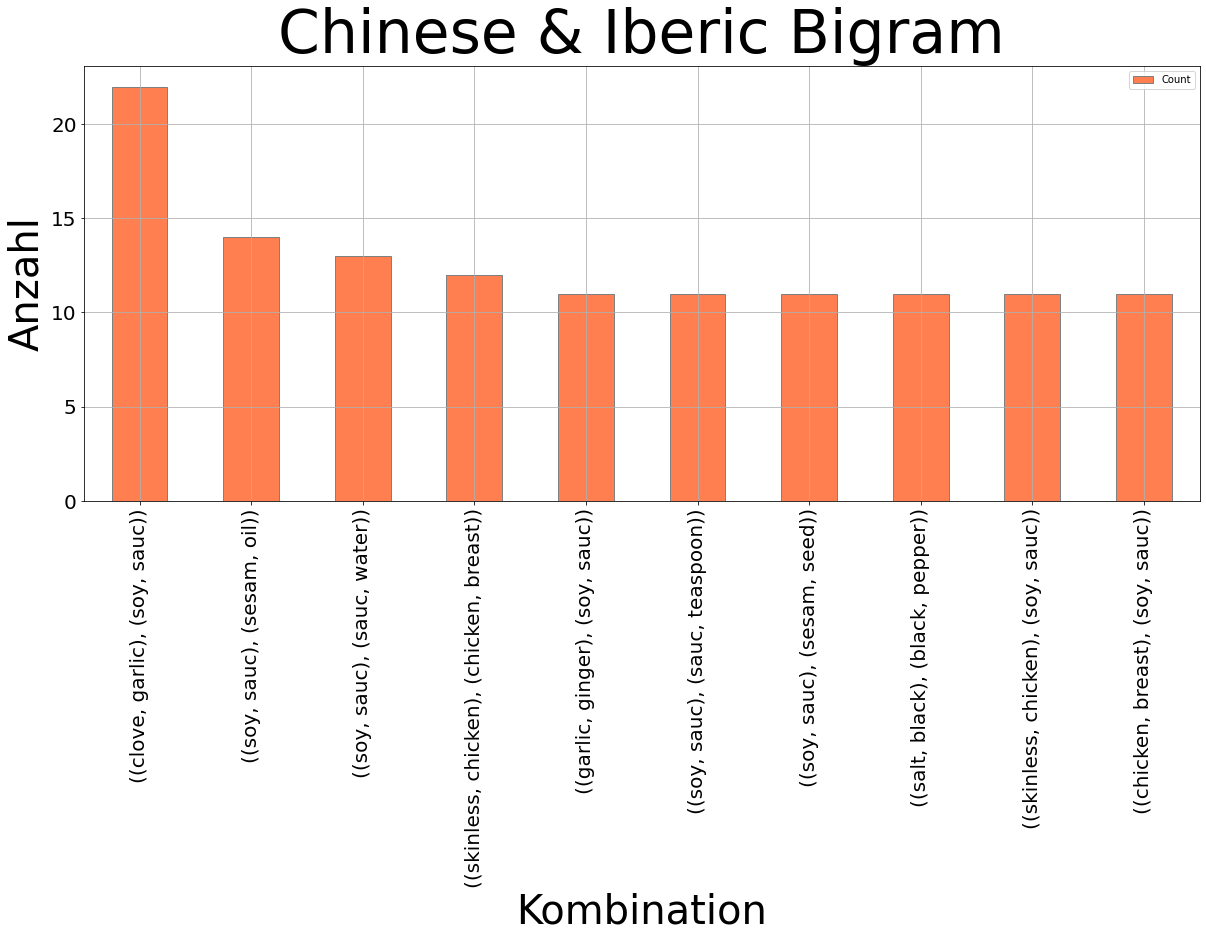

In [97]:
df4.plot.bar(x='Combination',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         xlabel = 'xlabel',
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

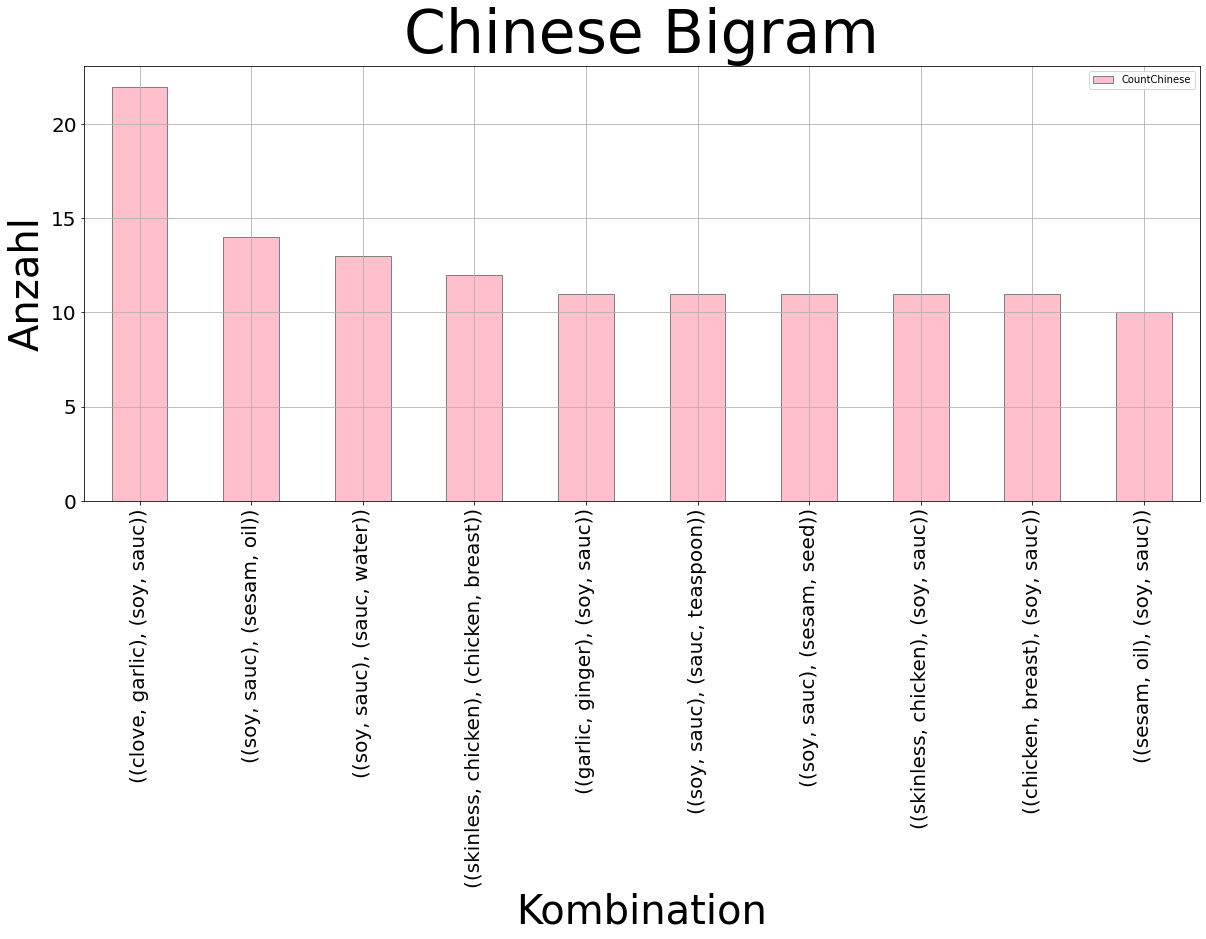

In [100]:
df4c.plot.bar(x='CombinationChinese',
         y='CountChinese', 
         color=['pink'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Chinese.png', bbox_inches = 'tight')
plt.show()

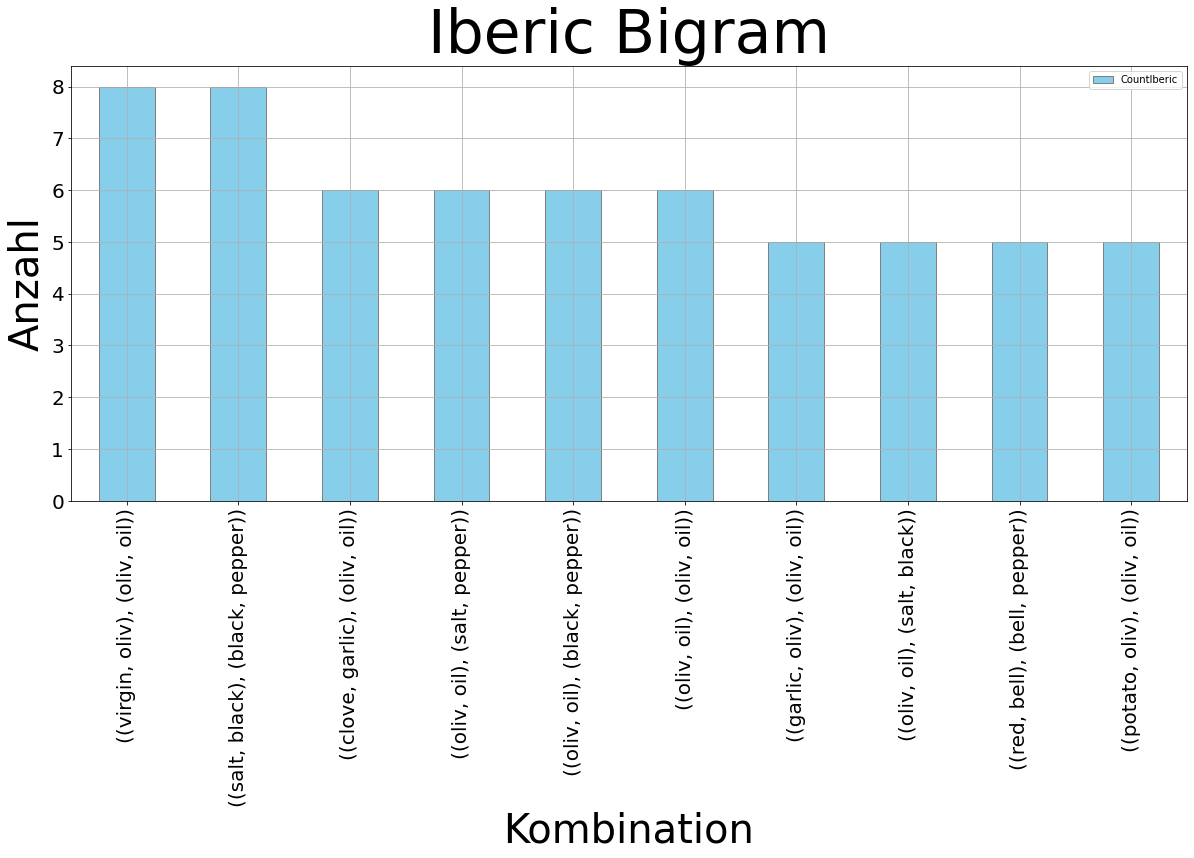

In [101]:
df4i.plot.bar(x='CombinationIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Iberic.png', bbox_inches = 'tight')
plt.show()

# A more intresting way to display data

In [102]:
import string
%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

In [103]:
nlp = spacy.load('en_core_web_sm')

In [105]:
new_df['parsed'] = new_df.cleanText.apply(nlp)
new_df.head(5)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams,number of ingredients,CLEAN number of ingredients,parsed
301,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr...",clove garlic ginger sesam oil rice vinegar soy...,"[clove, garlic, ginger, sesam, oil, rice, vine...","[(clove, garlic), (garlic, ginger), (ginger, s...",9,15,"(clove, garlic, ginger, sesam, oil, rice, vine..."
302,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken thigh oliv oil ginger clove garlic hon...,"[chicken, thigh, oliv, oil, ginger, clove, gar...","[(chicken, thigh), (thigh, oliv), (oliv, oil),...",8,14,"(chicken, thigh, oliv, oil, ginger, clove, gar..."
303,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg yellow onion carrot pea clove garli...,"[butter, egg, yellow, onion, carrot, pea, clov...","[(butter, egg), (egg, yellow), (yellow, onion)...",11,16,"(butter, egg, yellow, onion, carrot, pea, clov..."
304,Chinese,"['1 pound lean beef (cut into thin strips)', '...","['1 pound lean beef (cut into thin strips)', ...",beef soy sauc sherri oil yellow onion garlic g...,"[beef, soy, sauc, sherri, oil, yellow, onion, ...","[(beef, soy), (soy, sauc), (sauc, sherri), (sh...",17,23,"(beef, soy, sauc, sherri, oil, yellow, onion, ..."
305,Chinese,"['2 cloves garlic (minced)', '1 tablespoon fre...","['2 cloves garlic (minced)', '1 tablespoon fr...",clove garlic ginger sesam oil rice vinegar soy...,"[clove, garlic, ginger, sesam, oil, rice, vine...","[(clove, garlic), (garlic, ginger), (ginger, s...",9,14,"(clove, garlic, ginger, sesam, oil, rice, vine..."


In [106]:
corpus = st.CorpusFromParsedDocuments(new_df, category_col='cuisine', parsed_col='parsed').build()
print(corpus)

In [109]:
html = produce_scattertext_explorer(corpus,
                                    category='Chinese',
                                    category_name='Chinese',
                                    not_category_name='Iberic',
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    transform=st.Scalers.scale,
                                    metadata=new_df['cuisine'])
file_name = 'scattertext/ChineseIbericCusineScattertextScale.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)